In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
import seaborn as sns

from scipy.stats import skew, kurtosis, entropy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# explore the first dataset

data_path = "archive/2nd_test/2nd_test"

# check the data_path correct or not
print(os.path.exists(data_path)) 

True


In [3]:
# lists all files in this dataset
files = os.listdir(data_path)

# the 1st file path
file_1_path = os.path.join(data_path, files[0])  # Load the first file
# Read raw data (handling space/tab separation)
file_1_df = pd.read_csv(file_1_path, sep="\t", header=None)

print("How many files in this dataset? ", len(files))
print("How many data points in file? ", len(file_1_df))
print("how many columns in file 1? ", file_1_df.columns)

How many files in this dataset?  984
How many data points in file?  20480
how many columns in file 1?  Index([0, 1, 2, 3], dtype='int64')


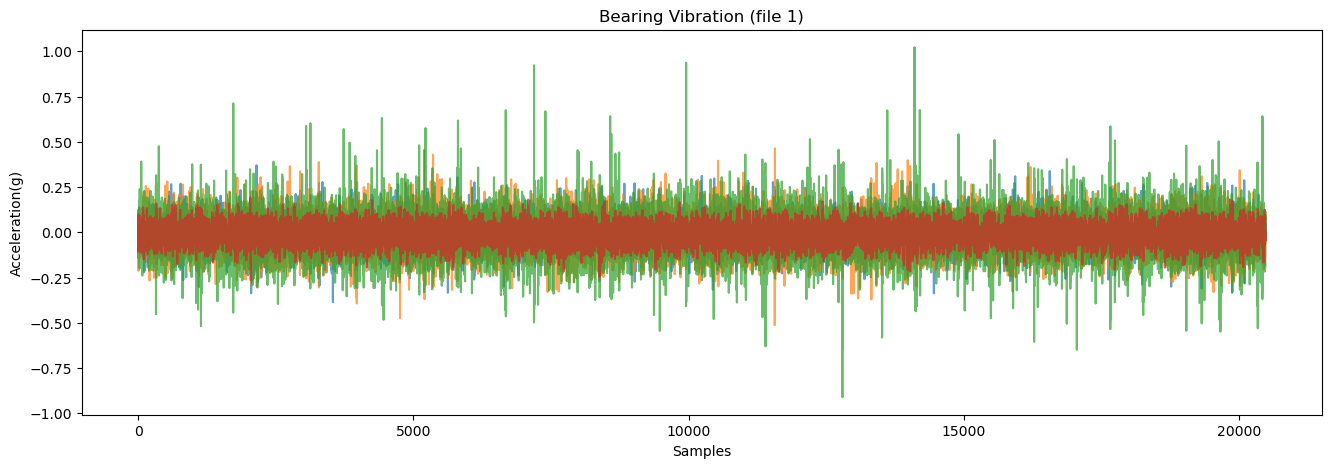

In [4]:
# first see the file 1

plt.figure(figsize=(16, 5))
plt.plot(file_1_df, alpha = 0.7)
plt.xlabel("Samples")
plt.ylabel("Acceleration(g)")
plt.title(f"Bearing Vibration (file 1)")

plt.show()

# This plot contains 4 sensor data (channels) overlapping

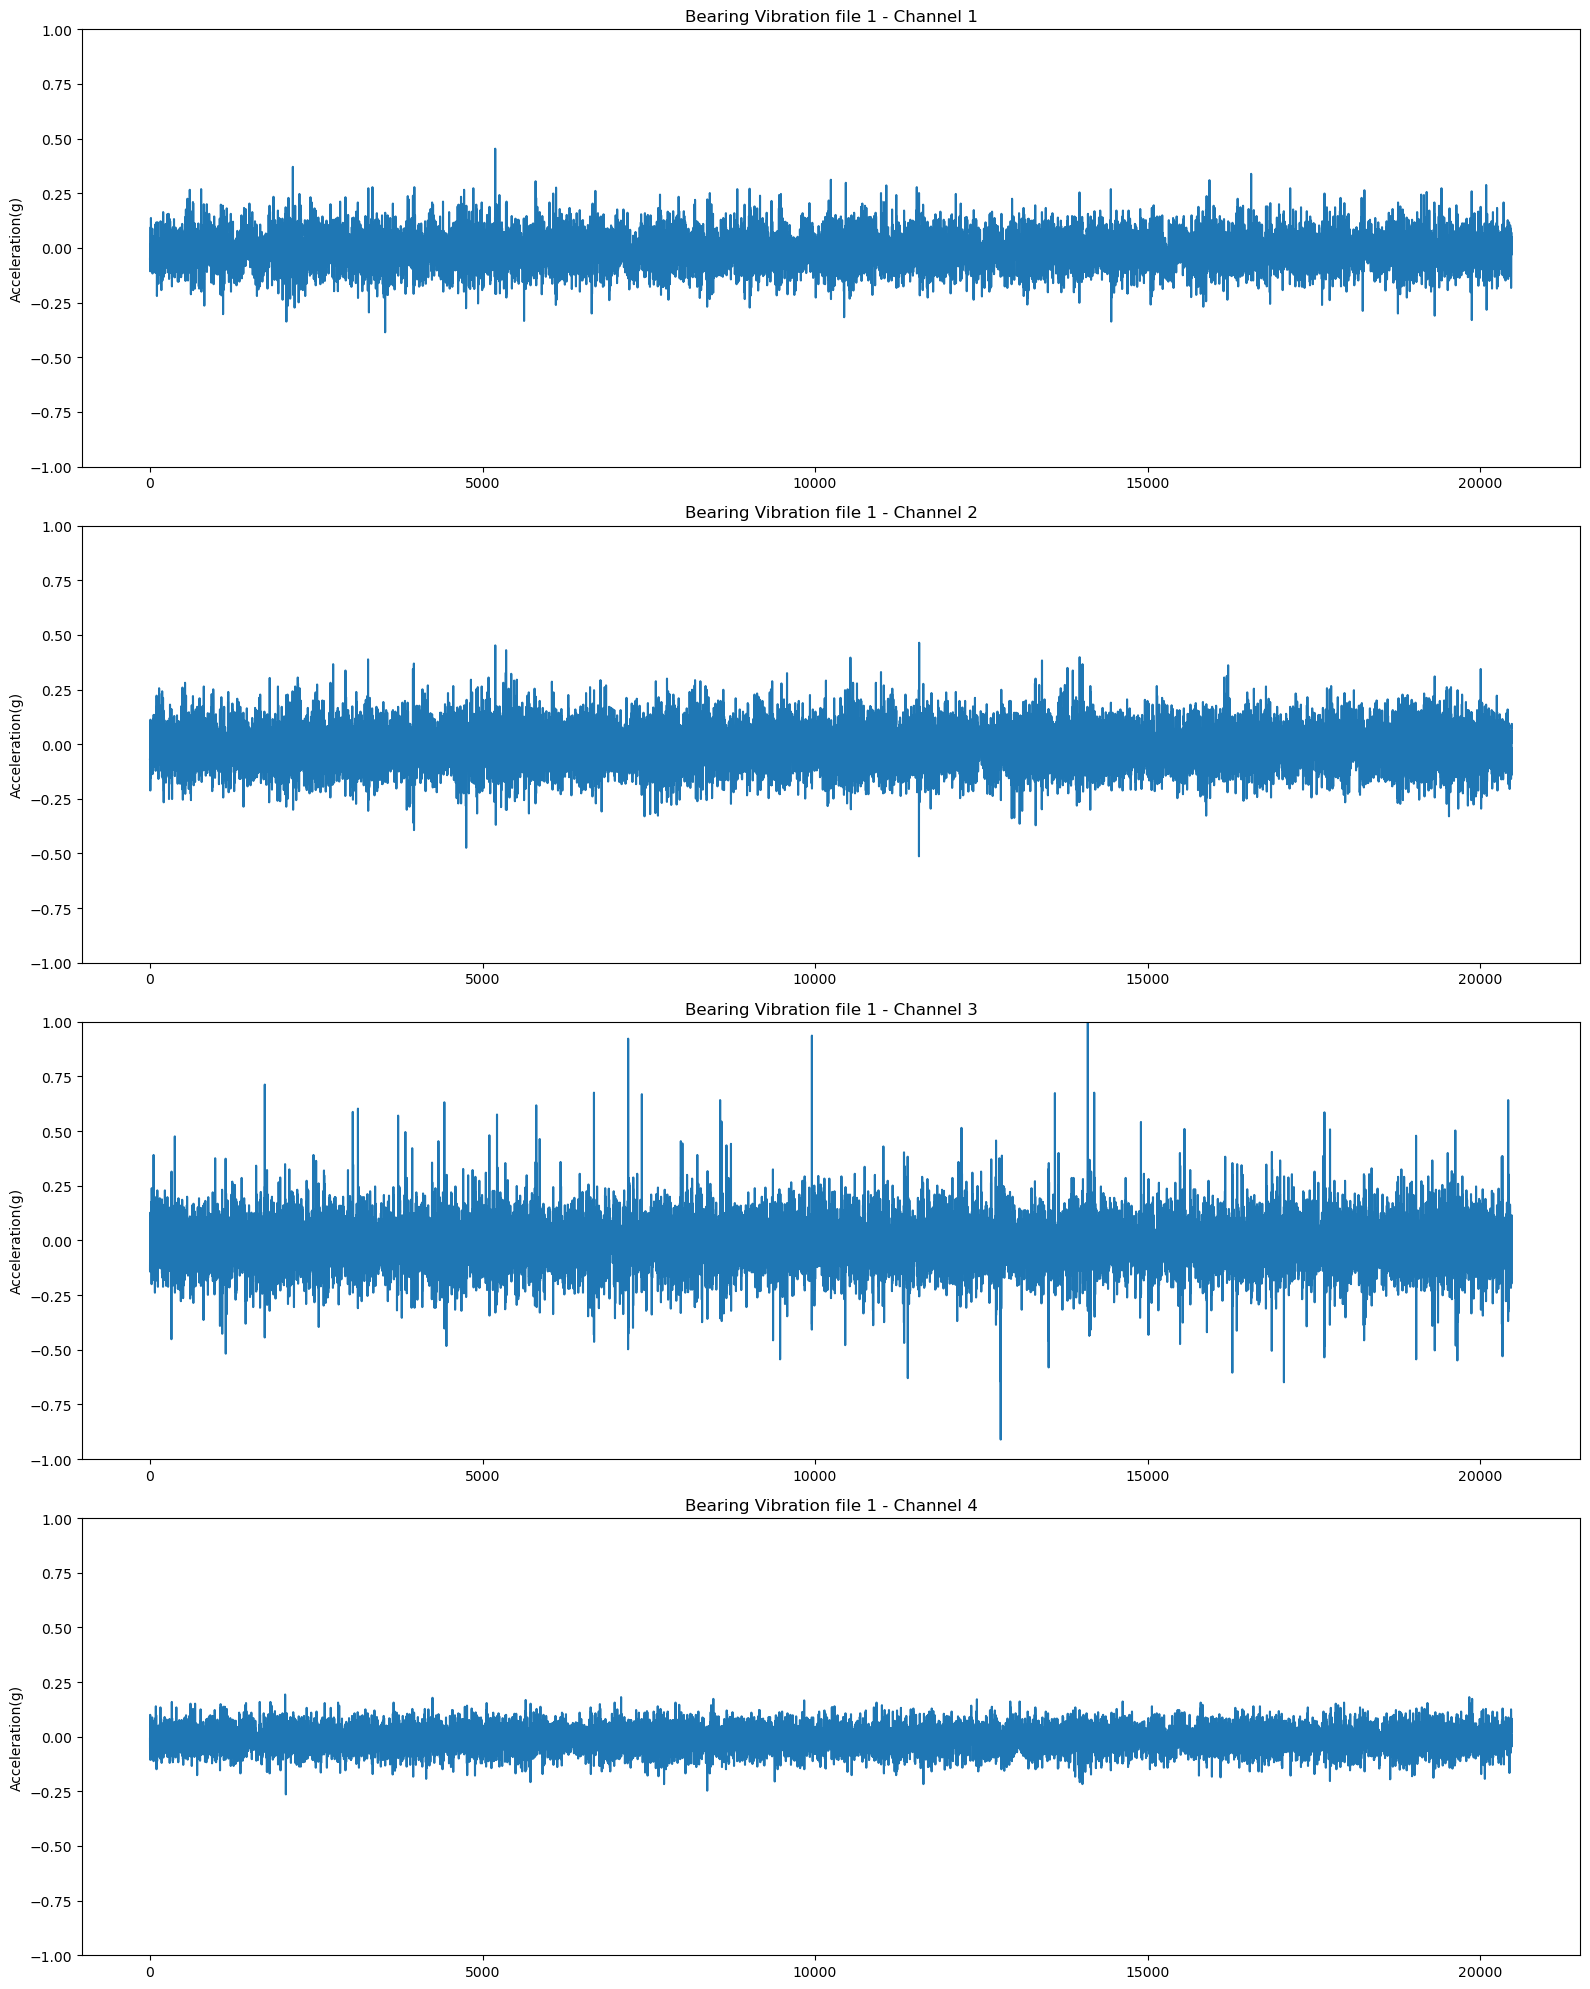

In [5]:
# each file has 20480 datapoints, and 4 columns (4 channels)

plt.figure(figsize=(16, 20))

for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(file_1_df.iloc[:, i], label=f"Channel {i+1}")
    plt.ylabel("Acceleration(g)")
    plt.ylim(-1, 1)
    plt.title(f"Bearing Vibration file 1 - Channel {i+1}")

    if i == 7:  # Add x-label only to the last subplot
        plt.xlabel("Samples")

plt.tight_layout()  # Prevents overlapping labels
plt.show()

In [6]:
# look at all files
# all files have the same number of data points?
len_raw_data =[]

for file in files:
    file_path = os.path.join(data_path, file)
    file_df = pd.read_csv(file_path, sep="\t", header=None)
    len_raw_data.append(len(file_df)) # Store data point counts

# Convert list to a pandas Series to use .describe()
len_raw_data_series = pd.Series(len_raw_data)

print(len_raw_data_series.describe())


count      984.0
mean     20480.0
std          0.0
min      20480.0
25%      20480.0
50%      20480.0
75%      20480.0
max      20480.0
dtype: float64


Information on this Dataset:

- 984 files in Dataset 1;
- Each file contains a single time-series recording of vibration data; (one second recording, as a sampling rate of 20.48 kHz (20,480 samples per second))
    - a time series recording has 20,480 data points (cycles)
    - a time series recording has 4 channels (columns)
- Since each file in Dataset 1 contains vibration data for 1 second, a total of 984 seconds would correspond to 16 mins and 24 seconds. (note that all recording interval is 10 min)


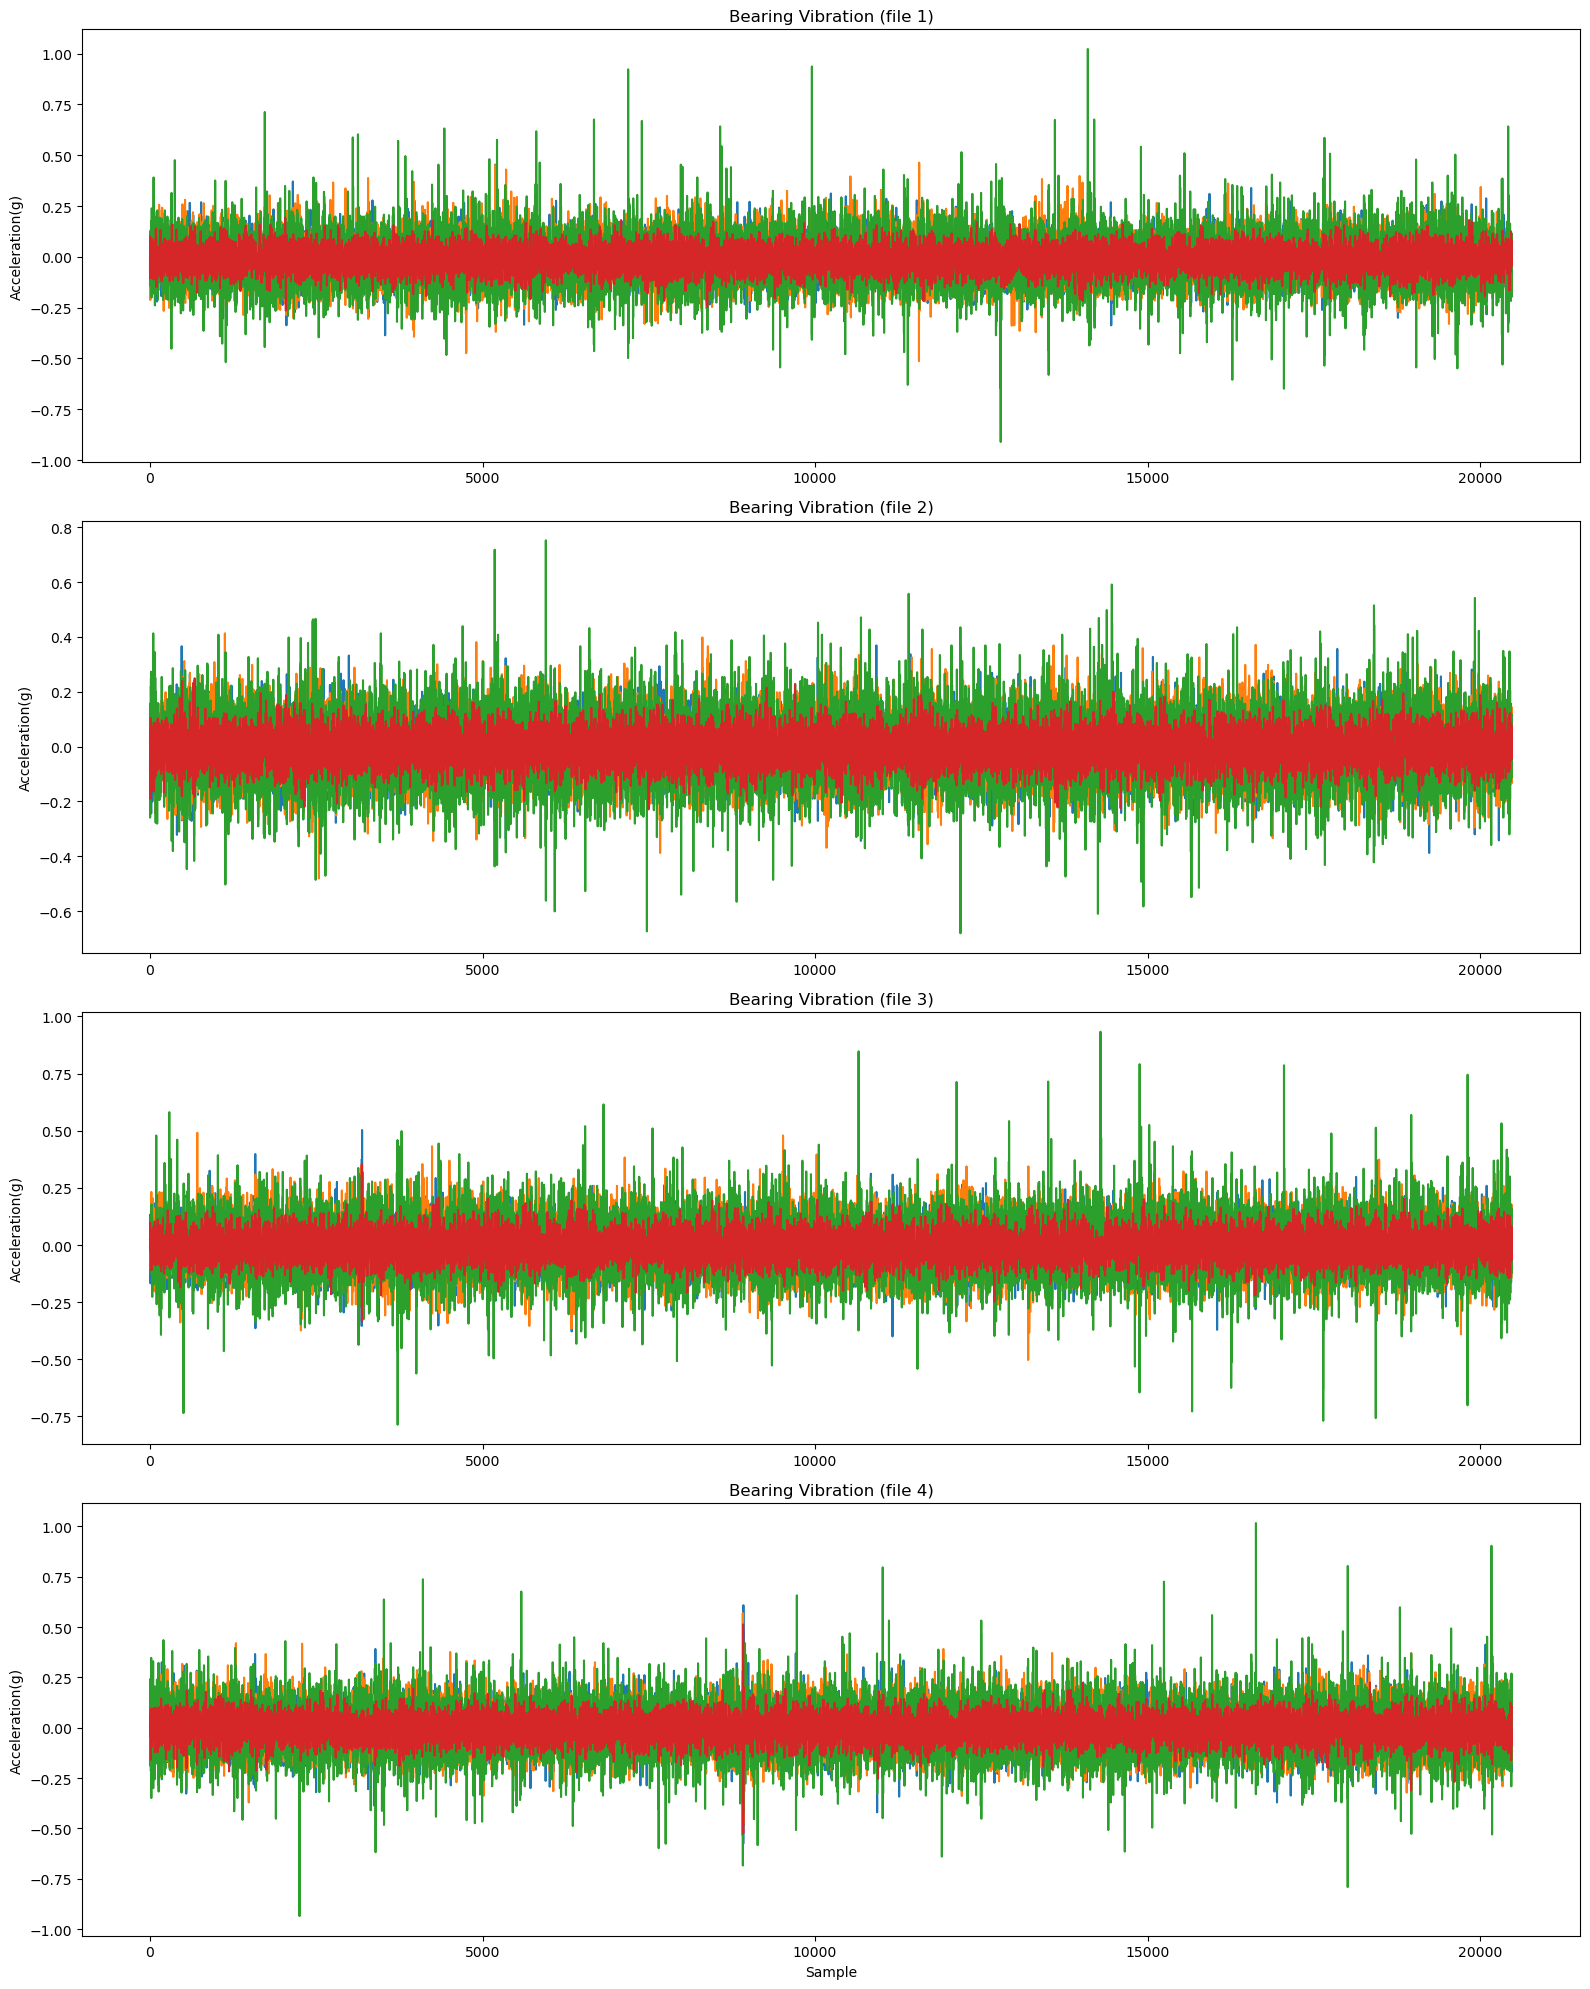

In [7]:
# plot the first fourth files

plt.figure(figsize=(16, 20))

for i, file in enumerate(files[:4]):
    file_path = os.path.join(data_path, file)
    file_df = pd.read_csv(file_path, sep="\t", header=None)

    plt.subplot(4, 1, i+1)
    plt.plot(file_df)
    plt.ylabel("Acceleration(g)")
    plt.title(f"Bearing Vibration (file {i+1})")

plt.xlabel("Sample")
plt.tight_layout()
plt.show()

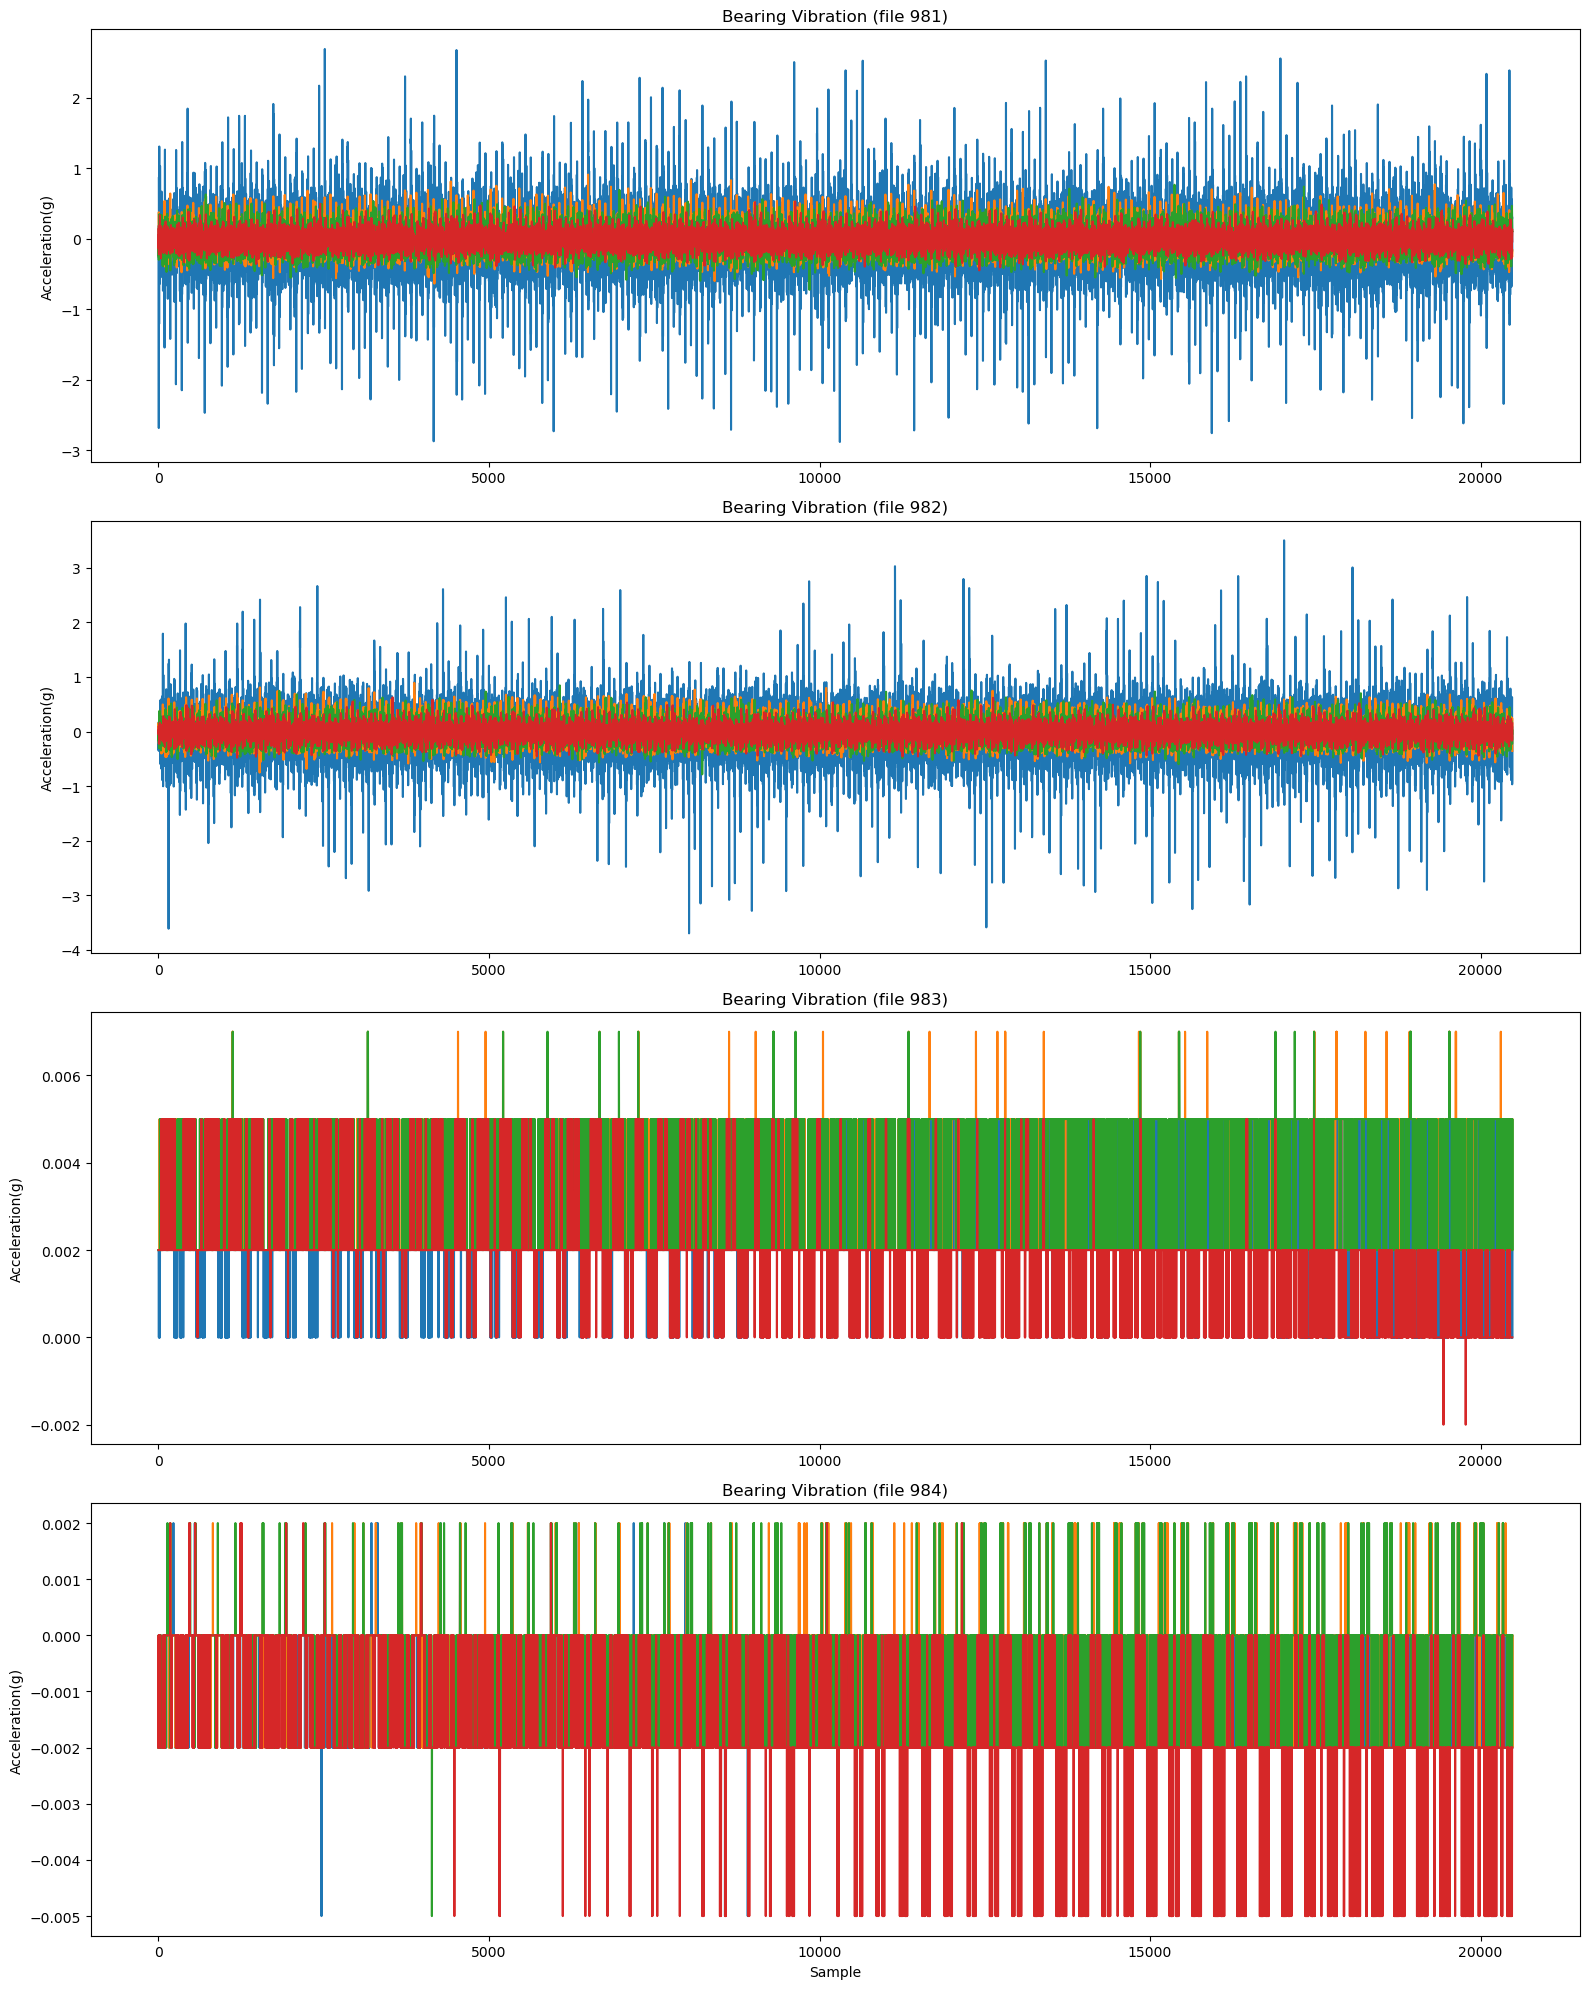

In [8]:
# plot the last fourth files

plt.figure(figsize=(16, 20))

for i, file in enumerate(files[-4:]):
    file_path = os.path.join(data_path, file)
    file_df = pd.read_csv(file_path, sep="\t", header=None)

    plt.subplot(4, 1, i+1)
    plt.plot(file_df)
    plt.ylabel("Acceleration(g)")
    plt.title(f"Bearing Vibration (file {len(files)-4+i+1})")

plt.xlabel("Sample")
plt.tight_layout()
plt.show()

# Feature Extraction

Feature extraction helps convert raw vibration signals into meaningful numerical values that can be used for fault detection, remaining useful life (RUL) prediction, and classification.

## Time-domain features

* ***Absolute Mean*** 

It measures the average absolute vibration level. Higher values may indicate increased wear or imbalance.

$$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***RMS:*** 

Indicates the overall energy content in the signal. Used for fault detection, as higher RMS suggests increased vibration due to damage.

$$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Standart Deviation:***

Quantifies how much the vibration deviates from the mean. A higher value suggests instability or possible defects.

$$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$

* ***Skewness:*** 

Measures asymmetry in the vibration distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.

$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$

* ***Kurtosis:***

Detects outliers and extreme peaks in the signal. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.

$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$

* ***Peak to Peak Amplitude (P2P):*** 

Measures the total range of vibration intensity. Large values suggest sudden impacts, imbalance, or misalignment.

$$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop. 
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 

Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults.

$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 

RMS divided by the mean of the absolute value. Shape factor is dependent on the signal shape while being independent of the signal dimensions.

$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse Factor:*** 

Compare the height of a peak to the mean level of the signal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$

* ***Shannon entropy:*** 

Shannon entropy measures the randomness or uncertainty in a time-domain signal.
It is computed from the probability distribution of signal values.
- Higher entropy = more randomness (noisy signal).
- Lower entropy = less randomness (structured or periodic signal).

$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$

in Vibration Analysis:It identifies changes in signal randomness.
Can be used to detect abnormal vibration behavior before failure.

## Frequency-domain features

* ***Entropy （Spectral Entropy （natural log））:***

It quantifies the disorder or randomness in the spectral distribution.

It is computed after applying FFT (Fast Fourier Transform) to convert the time-domain signal into the frequency domain.

$$ H(X) = -\sum_{i=1}^{N} P(f_i)\log{P(f_i)} $$

P(f_i) is the normalized power spectral density (PSD). The sum is taken over all frequency bins.

                            
* ***Energy (\(K_2\))***:

It represents the **total energy** of the vibration signal.

Higher values indicate stronger vibrations, which may be due to **bearing faults**.

$$  K_2 = \int A^2 dt $$


* ***Entropy-Based Feature (\(K_3\))***:

It quantifies the randomness in the **vibration signal energy**.

Higher values suggest **irregular vibrations**, which may indicate **bearing defects** or **progressive wear**.
$$
  K_3 = \int \frac{A^2}{K_2} \ln \left(\frac{A^2}{K_2} \right) dt
$$

In [9]:
# define function to calculate time-domain features (including shanon entropy)

def time_feature_calculation(signal):
    """
    Computes time-domain features.
    Parameters:
        signal (Series): Vibration signal data.

    Returns:
        dict: Dictionary of computed features.
    """

    # set a small value to prevent division errors
    eps = 1e-10  

    rms_value = np.sqrt(np.mean(signal ** 2))  # Root Mean Square
    mean_abs = np.mean(np.abs(signal))
    max_abs = np.max(np.abs(signal))  

    # Shannon Entropy ((Discretize signal into 500 bins)) 将信号离散化为 500 个 bin
    hist = np.histogram(signal, bins=500)[0]    # return the first output "bin counts"
    hist = hist / np.sum(hist)                  # convert bin counts into probabilities
    signal_entropy = entropy(hist + eps) # apply entropy fomular

    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'skew': skew(signal),
        'kurtosis': kurtosis(signal),
        'rms': rms_value,
        'max': np.max(signal),
        'p2p': np.ptp(signal),  # Peak-to-Peak
        'crest': max_abs / (rms_value + eps),  # Crest Factor
        'clearance': max_abs / (np.mean(np.sqrt(np.abs(signal)))**2 + eps),  # Clearance Factor
        'shape': rms_value / (mean_abs + eps),  # Shape Factor
        'impulse': max_abs / (mean_abs + eps),  # Impulse Factor
        "entropy": signal_entropy
    }

In [10]:
# Function to compute time-domain features for NASA Bearing Dataset 1
def time_features(dataset_path):
    """
    Compute time-domain features for each file 
    Parameters:
        dataset_path (str): Path to the dataset folder.
    Returns:
        pandas DataFrame: Extracted time-domain features.
    """

    columns = ['B1', 'B2', 'B3', 'B4']  

    data = []

    # Get all files in the dataset directory
    files = os.listdir(dataset_path)
    
    for file in files:
 
        file_path = os.path.join(dataset_path, file)
        df = pd.read_csv(file_path, sep="\t", header=None)  

        # create a dict to store features
        row_features = {"file_name": file}  

        for col in range(df.shape[1]):  # Iterate through each sensor/channel column, because calculation is done by columns
            features = time_feature_calculation(df.iloc[:, col]) 
            channel_name = columns[col]  

            for key, value in features.items():
                row_features[f"{channel_name}_{key}"] = value  # Store features with correct names

        data.append(row_features)  # Append row features

    # Convert list to DataFrame
    return pd.DataFrame(data)

In [11]:
data_path = "archive/2nd_test/2nd_test"

df = time_features(data_path)

df

,file_name,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_rms,B1_max,B1_p2p,B1_crest,B1_clearance,...,B4_skew,B4_kurtosis,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearance,B4_shape,B4_impulse,B4_entropy
0,2004.02.12.10.32.39,-0.010196,0.073475,0.083993,0.628763,0.074179,0.454,0.840,6.120331,9.258404,...,-0.022080,0.065959,0.054103,0.193,0.457,4.879539,7.281349,1.256323,6.130277,4.494223
1,2004.02.12.10.42.39,-0.002585,0.075338,0.052142,0.648291,0.075382,0.369,0.757,5.147086,7.834513,...,0.001582,0.107539,0.056101,0.249,0.478,4.438435,6.646340,1.259563,5.590488,4.545821
2,2004.02.12.10.52.39,-0.002484,0.076189,0.032808,0.513475,0.076230,0.503,0.903,6.598472,9.907938,...,0.070449,0.257236,0.056145,0.354,0.688,6.305078,9.483004,1.263337,7.965439,4.544766
3,2004.02.12.11.02.39,-0.002277,0.078691,0.041486,1.157953,0.078724,0.608,1.184,7.723217,11.794197,...,-0.036327,0.806190,0.056807,0.513,1.038,9.241749,13.819612,1.260116,11.645678,4.553724
4,2004.02.12.11.12.39,-0.002404,0.078437,0.028224,0.603177,0.078474,0.391,0.782,4.982524,7.622802,...,0.019008,0.138954,0.056841,0.244,0.456,4.292680,6.429704,1.259820,5.408004,4.560095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,2004.02.19.05.42.39,-0.002752,0.724996,-0.510556,12.577705,0.725001,4.998,9.998,6.896538,14.191571,...,-0.051948,-0.093287,0.148351,0.542,1.086,3.666976,5.376978,1.246204,4.569801,5.447635
980,2004.02.19.05.52.39,-0.004487,0.461990,-0.325368,3.759972,0.462012,2.688,5.569,6.235773,10.401209,...,0.119893,0.259591,0.116630,0.527,0.976,4.518571,6.804165,1.266029,5.720640,5.271184
981,2004.02.19.06.02.39,-0.001703,0.483832,-0.377095,4.891755,0.483835,3.501,7.197,7.638962,12.857363,...,0.167978,0.697167,0.130582,0.625,1.104,4.786252,7.451689,1.295288,6.199577,5.302012
982,2004.02.19.06.12.39,0.001857,0.000987,0.579698,3.637513,0.002103,0.005,0.005,2.377543,3.192021,...,0.656680,1.652722,0.002154,0.005,0.007,2.321622,3.649668,1.205903,2.799650,0.758392


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     984 non-null    object 
 1   B1_mean       984 non-null    float64
 2   B1_std        984 non-null    float64
 3   B1_skew       984 non-null    float64
 4   B1_kurtosis   984 non-null    float64
 5   B1_rms        984 non-null    float64
 6   B1_max        984 non-null    float64
 7   B1_p2p        984 non-null    float64
 8   B1_crest      984 non-null    float64
 9   B1_clearance  984 non-null    float64
 10  B1_shape      984 non-null    float64
 11  B1_impulse    984 non-null    float64
 12  B1_entropy    984 non-null    float64
 13  B2_mean       984 non-null    float64
 14  B2_std        984 non-null    float64
 15  B2_skew       984 non-null    float64
 16  B2_kurtosis   984 non-null    float64
 17  B2_rms        984 non-null    float64
 18  B2_max        984 non-null    

In [13]:
df.describe()

,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_rms,B1_max,B1_p2p,B1_crest,B1_clearance,B1_shape,...,B4_skew,B4_kurtosis,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearance,B4_shape,B4_impulse,B4_entropy
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,-0.001943,0.106087,-0.033123,0.827138,0.106111,0.527163,1.054736,5.173870,8.085720,1.296404,...,-0.001424,0.141657,0.060269,0.260435,0.527398,4.627472,6.928453,1.259826,5.830338,4.597510
std,0.000501,0.058231,0.089029,0.965787,0.058224,0.362879,0.740102,0.576209,1.085703,0.047856,...,0.058082,0.118328,0.012190,0.056828,0.098904,0.526146,0.791893,0.006187,0.667344,0.224411
min,-0.010196,0.000987,-0.766067,-1.609774,0.001533,0.002000,0.005000,2.377543,3.192021,1.132578,...,-0.659119,-0.341303,0.002124,0.002000,0.007000,2.321622,3.649668,1.205903,2.799650,0.758392
25%,-0.002167,0.077108,-0.047506,0.393747,0.077137,0.377500,0.752000,4.816583,7.391662,1.268805,...,-0.023064,0.086372,0.055342,0.229000,0.474000,4.298590,6.451926,1.257311,5.428111,4.532539
50%,-0.001944,0.078745,-0.009859,0.484787,0.078778,0.422000,0.830000,5.097702,7.897797,1.273184,...,-0.007895,0.128655,0.056075,0.247000,0.503000,4.540700,6.799289,1.259244,5.720658,4.545723
75%,-0.001723,0.108787,0.013705,0.878688,0.108819,0.557000,1.101750,5.440354,8.579333,1.304257,...,0.009483,0.174850,0.060498,0.273000,0.552000,4.816952,7.231215,1.261635,6.077387,4.621887
max,0.003389,0.724996,0.579698,14.110009,0.725001,4.998000,9.998000,9.333270,17.640492,1.612963,...,0.656680,1.652722,0.148351,0.706000,1.272000,9.241749,13.819612,1.321145,11.645678,5.447635


In [14]:
df.shape

(984, 49)

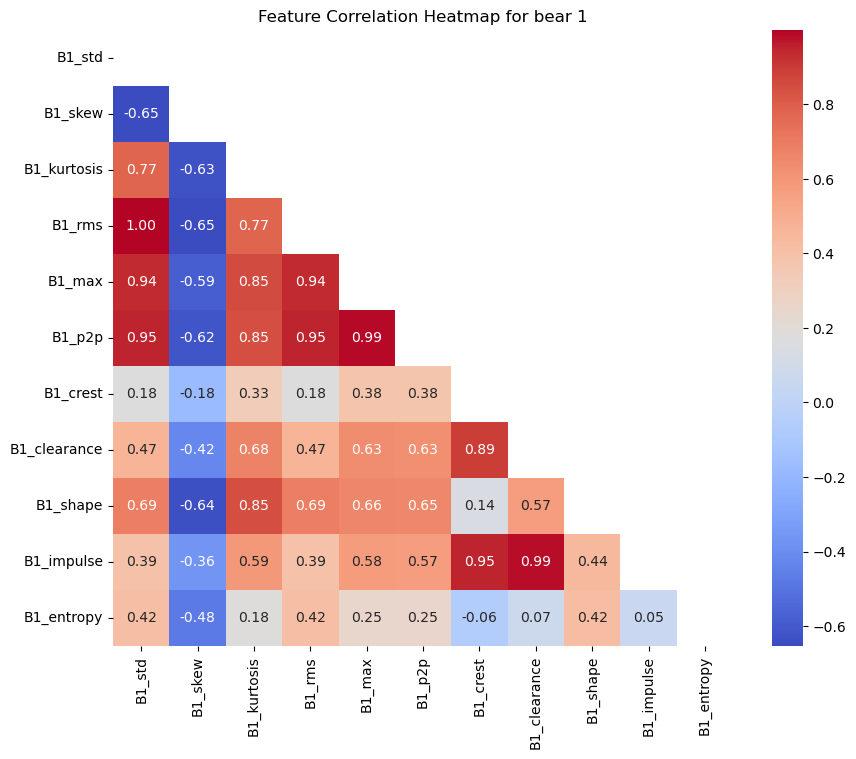

B1_rms        B1_std          1.000000
B1_max        B1_std          0.941250
              B1_kurtosis     0.853275
              B1_rms          0.941272
B1_p2p        B1_std          0.951809
              B1_kurtosis     0.847230
              B1_rms          0.951832
              B1_max          0.992768
B1_clearance  B1_crest        0.891242
B1_shape      B1_kurtosis     0.847894
B1_impulse    B1_crest        0.949866
              B1_clearance    0.986727
dtype: float64

In [15]:
df_bear1 = df.filter(like="B1_", axis=1)

corr_matrix = df_bear1.iloc[:,1:].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title("Feature Correlation Heatmap for bear 1")
plt.show()

# Print correlations greater than 0.8 (excluding self-correlation of 1.0)
high_corr_pairs = corr_matrix.abs().where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.8]
high_corr_pairs

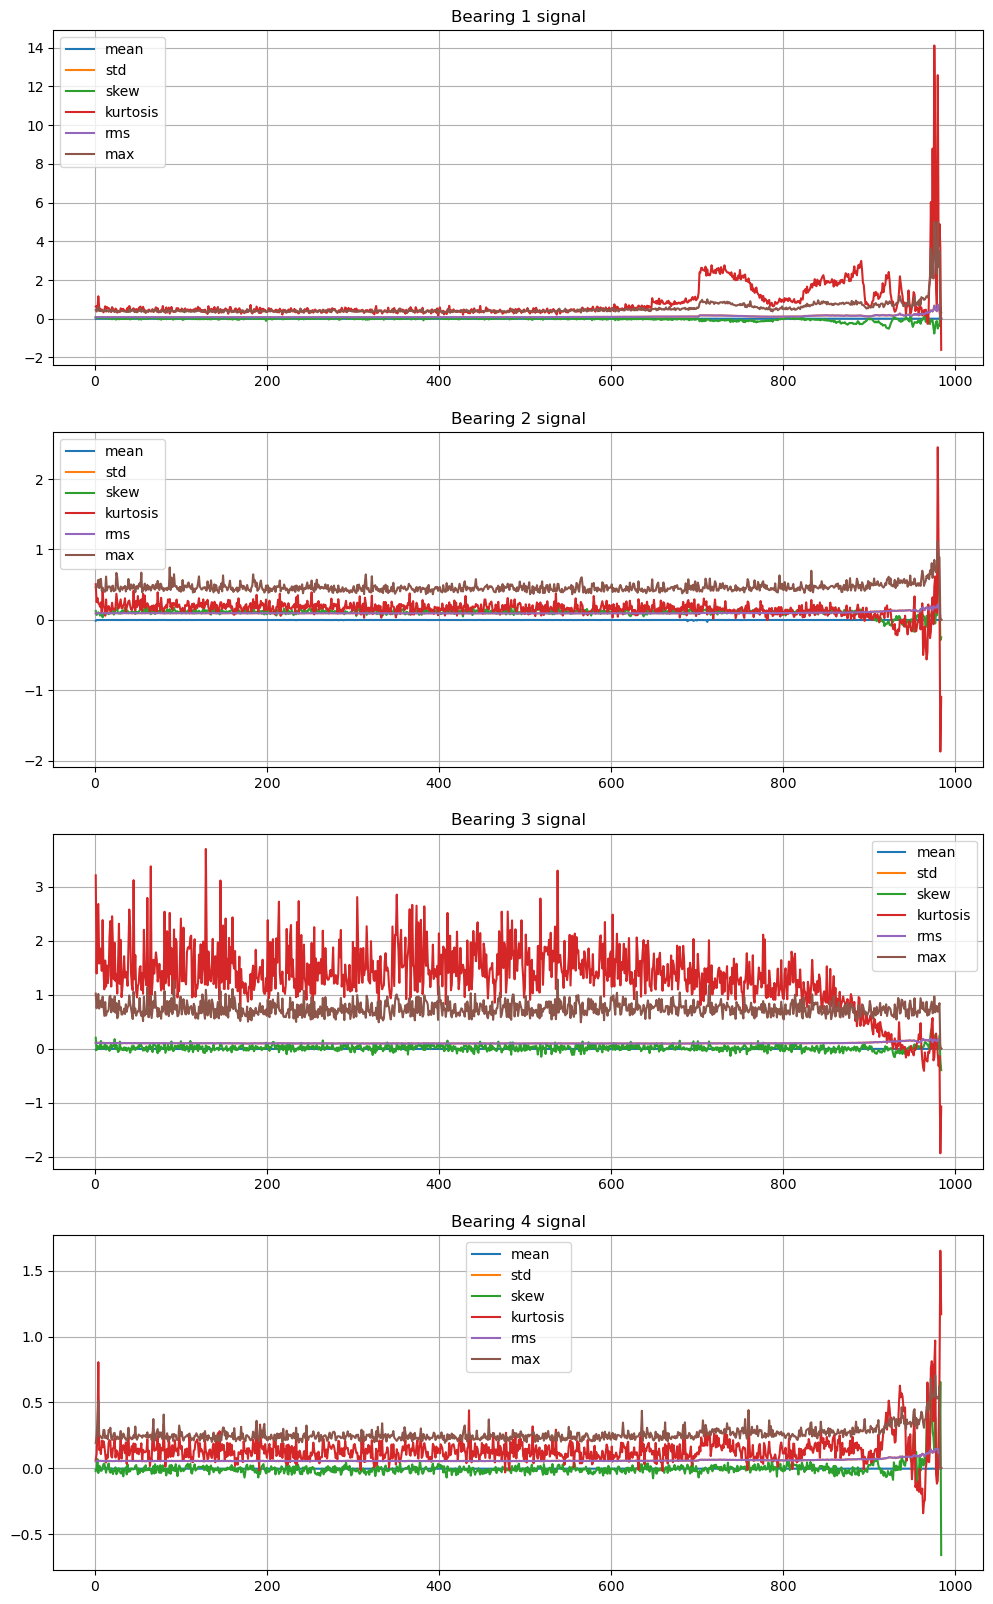

In [16]:
# plot the first 6 features

df["time"] = range(1, len(df)+1)

# select features
features_1 = ['mean', 'std', 'skew', 'kurtosis', 'rms', 'max']

plt.figure(figsize = (12, 20))

for i in range(1, 5):
    plt.subplot(4, 1, i)

    for feature in features_1:
        plt.plot(df['time'], df[f'B{i}_{feature}'], label=feature)
    
    plt.title(f'Bearing {i} signal')

    plt.legend()
    plt.grid()

plt.show()

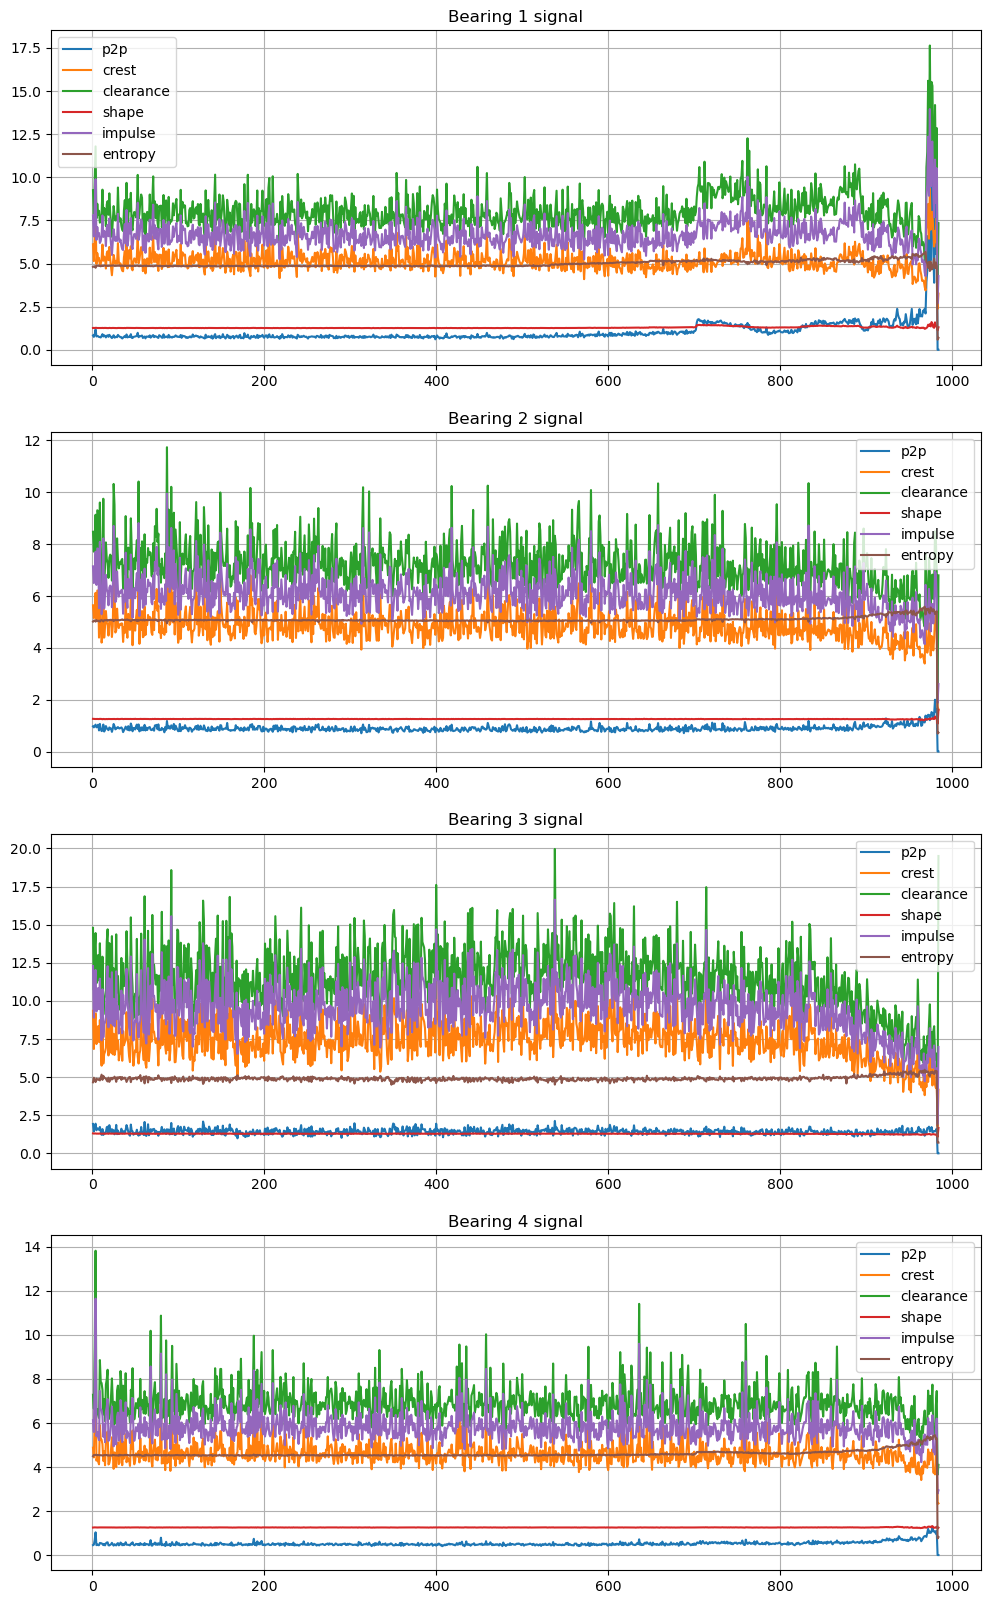

In [17]:
# plot the last 6 features

df["time"] = range(1, len(df)+1)

# select features
features_2 = ['p2p', 'crest', 'clearance', 'shape', 'impulse', 'entropy']

plt.figure(figsize = (12, 20))

for i in range(1, 5):
    plt.subplot(4, 1, i)

    for feature in features_2:
        plt.plot(df['time'], df[f'B{i}_{feature}'], label=feature)
    
    plt.title(f'Bearing {i} signal')

    plt.legend()
    plt.grid()


## Anomaly Detection - 3-Sigma Rule

One of the most common threhold for Z-score based Anomaly Detection is considering the data points with Z-scores greater than +- 3 as potential outliers.
Because based 
99.7 % of data points fall into 3 S.D. of the mean (68-95-99.7), so z-score >=3 's data points can be considered as outliers.

**root mean square**:

Here i select "RMS" as the feature to do the anomaly detection:
- RMS quantifies the overall vibration intensity. When a bearing starts to fail, it generates more vibrations, which increases RMS.
A sudden rise in RMS often signals bearing degradation or mechanical failure.

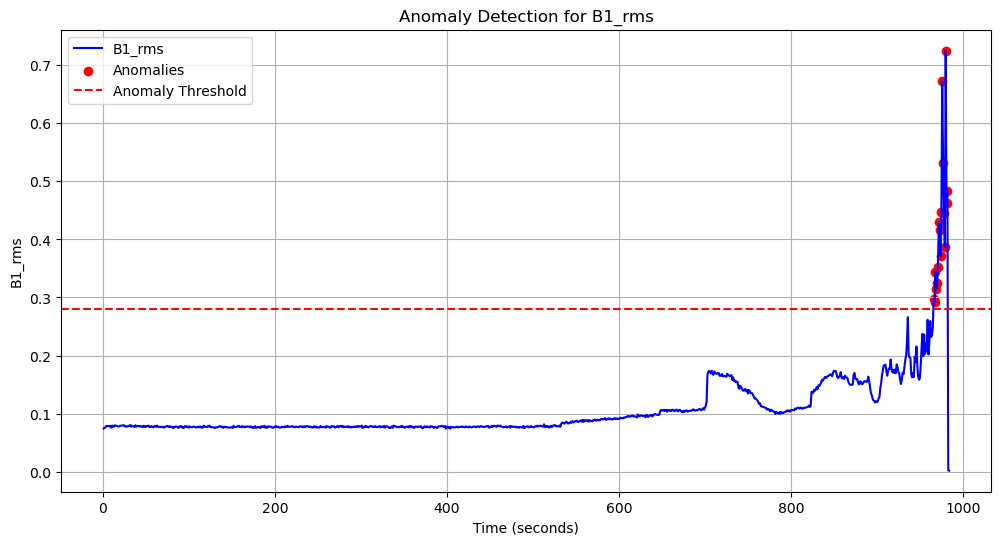

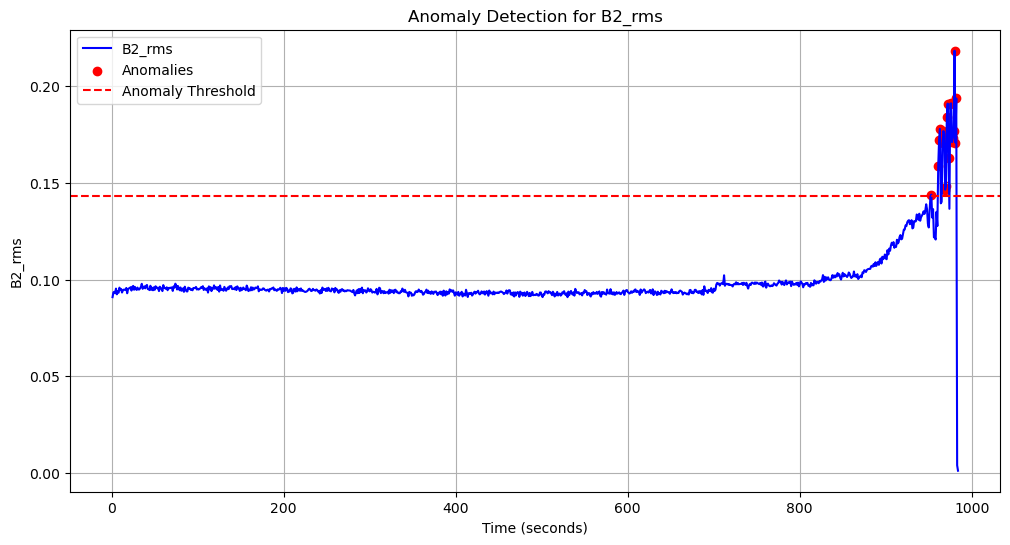

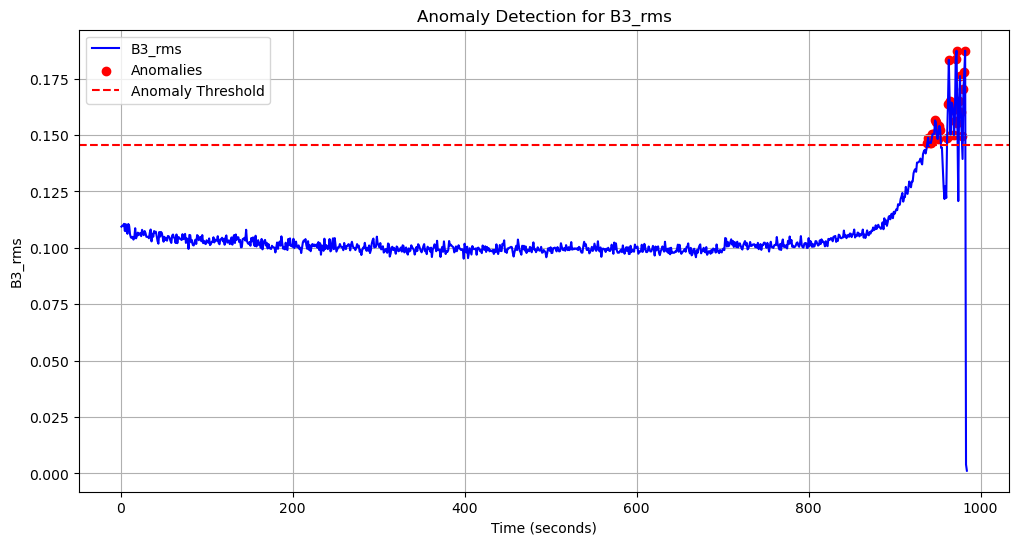

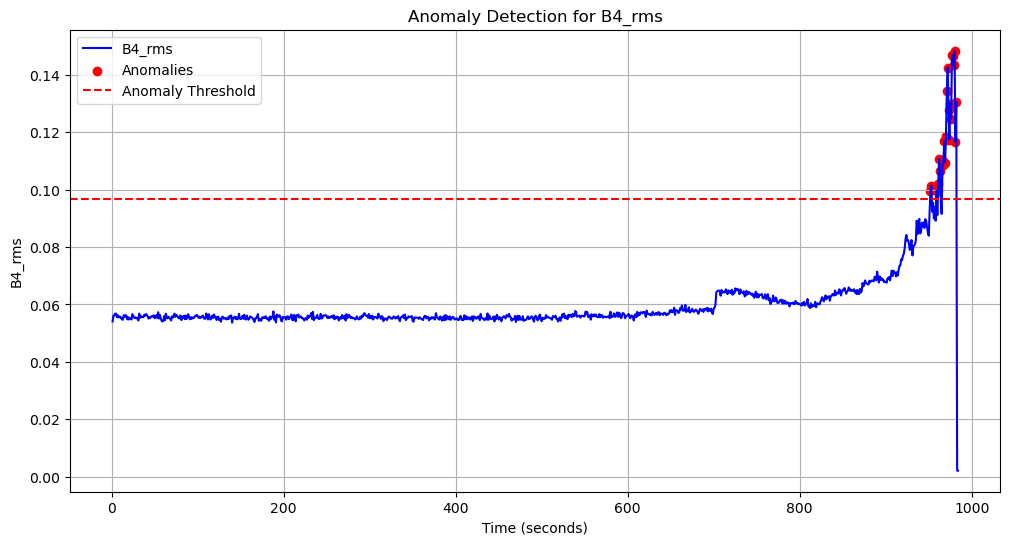

In [18]:
# Define anomaly threshold
threshold_factor = 3

# Select the feature: root mean square
features = ["B1_rms", "B2_rms", "B3_rms", "B4_rms"]

for feature in features:      
 
    mean_value = df[feature].mean()
    std_dev = df[feature].std()
    threshold = mean_value + threshold_factor * std_dev

    # Store anomalies in separate columns
    df[f"{feature}_anomaly"] = df[feature] > threshold

    plt.figure(figsize=(12, 6))
    plt.plot(df["time"], df[feature], label=feature, color="blue")
    
    # Highlight anomaly points
    plt.scatter(df[df[f"{feature}_anomaly"]]["time"], 
                df[df[f"{feature}_anomaly"]][feature], 
                color="red", label="Anomalies")
    
    # add the threshold line
    plt.axhline(threshold, color="red", linestyle="dashed", label="Anomaly Threshold")
    
    plt.xlabel("Time (seconds)")
    plt.ylabel(feature)
    plt.title(f"Anomaly Detection for {feature}")
    plt.legend()
    plt.grid()
    plt.show()

Bearing 1 (B1) Shows Strong Failure Trend

Sharp increase in RMS after Cycle ~900, indicating progressive degradation.
Anomalies (red dots) are detected well before failure.
The failure threshold (dashed line) is crossed just before Cycle 980-984, aligning with the known outer race failure.
Unexpected Anomalies in Bearings 2, 3, and 4

All bearings show a late RMS increase (~900+ cycles).
Since only Bearing 1 had actual failure, this could be:
Shared load impact (e.g., Bearing 1 failure affecting the others).
System-wide operational changes near the end.
Sensor or environmental noise.


In [19]:
df.drop(columns = ["B1_rms_anomaly", 'B2_rms_anomaly', 'B3_rms_anomaly', 'B4_rms_anomaly'], inplace=True)
df

,file_name,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_rms,B1_max,B1_p2p,B1_crest,B1_clearance,...,B4_kurtosis,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearance,B4_shape,B4_impulse,B4_entropy,time
0,2004.02.12.10.32.39,-0.010196,0.073475,0.083993,0.628763,0.074179,0.454,0.840,6.120331,9.258404,...,0.065959,0.054103,0.193,0.457,4.879539,7.281349,1.256323,6.130277,4.494223,1
1,2004.02.12.10.42.39,-0.002585,0.075338,0.052142,0.648291,0.075382,0.369,0.757,5.147086,7.834513,...,0.107539,0.056101,0.249,0.478,4.438435,6.646340,1.259563,5.590488,4.545821,2
2,2004.02.12.10.52.39,-0.002484,0.076189,0.032808,0.513475,0.076230,0.503,0.903,6.598472,9.907938,...,0.257236,0.056145,0.354,0.688,6.305078,9.483004,1.263337,7.965439,4.544766,3
3,2004.02.12.11.02.39,-0.002277,0.078691,0.041486,1.157953,0.078724,0.608,1.184,7.723217,11.794197,...,0.806190,0.056807,0.513,1.038,9.241749,13.819612,1.260116,11.645678,4.553724,4
4,2004.02.12.11.12.39,-0.002404,0.078437,0.028224,0.603177,0.078474,0.391,0.782,4.982524,7.622802,...,0.138954,0.056841,0.244,0.456,4.292680,6.429704,1.259820,5.408004,4.560095,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,2004.02.19.05.42.39,-0.002752,0.724996,-0.510556,12.577705,0.725001,4.998,9.998,6.896538,14.191571,...,-0.093287,0.148351,0.542,1.086,3.666976,5.376978,1.246204,4.569801,5.447635,980
980,2004.02.19.05.52.39,-0.004487,0.461990,-0.325368,3.759972,0.462012,2.688,5.569,6.235773,10.401209,...,0.259591,0.116630,0.527,0.976,4.518571,6.804165,1.266029,5.720640,5.271184,981
981,2004.02.19.06.02.39,-0.001703,0.483832,-0.377095,4.891755,0.483835,3.501,7.197,7.638962,12.857363,...,0.697167,0.130582,0.625,1.104,4.786252,7.451689,1.295288,6.199577,5.302012,982
982,2004.02.19.06.12.39,0.001857,0.000987,0.579698,3.637513,0.002103,0.005,0.005,2.377543,3.192021,...,1.652722,0.002154,0.005,0.007,2.321622,3.649668,1.205903,2.799650,0.758392,983


In [20]:
df_bear1

,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_rms,B1_max,B1_p2p,B1_crest,B1_clearance,B1_shape,B1_impulse,B1_entropy
0,-0.010196,0.073475,0.083993,0.628763,0.074179,0.454,0.840,6.120331,9.258404,1.271660,7.782979,4.811389
1,-0.002585,0.075338,0.052142,0.648291,0.075382,0.369,0.757,5.147086,7.834513,1.277742,6.576647,4.835319
2,-0.002484,0.076189,0.032808,0.513475,0.076230,0.503,0.903,6.598472,9.907938,1.265456,8.350077,4.848371
3,-0.002277,0.078691,0.041486,1.157953,0.078724,0.608,1.184,7.723217,11.794197,1.281033,9.893696,4.761538
4,-0.002404,0.078437,0.028224,0.603177,0.078474,0.391,0.782,4.982524,7.622802,1.278896,6.372127,4.875057
...,...,...,...,...,...,...,...,...,...,...,...,...
979,-0.002752,0.724996,-0.510556,12.577705,0.725001,4.998,9.998,6.896538,14.191571,1.599323,11.029794,4.741739
980,-0.004487,0.461990,-0.325368,3.759972,0.462012,2.688,5.569,6.235773,10.401209,1.368621,8.534412,5.060517
981,-0.001703,0.483832,-0.377095,4.891755,0.483835,3.501,7.197,7.638962,12.857363,1.378077,10.527081,4.847929
982,0.001857,0.000987,0.579698,3.637513,0.002103,0.005,0.005,2.377543,3.192021,1.132578,2.692753,0.592368


In [21]:
# Standardize the data as PCA is affected by differences in feature scale.

features_to_select = ['kurtosis', 'max', 'clearance']

feature_columns = [f'B1_{feature}' for feature in features_to_select]

scaler = StandardScaler()
df_bear1_scaled = scaler.fit_transform(df_bear1[feature_columns])

In [22]:
pca = PCA(n_components=1)
principal_components = pca.fit_transform(df_bear1_scaled)

print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.4f}")

Explained variance by PC1: 0.8153


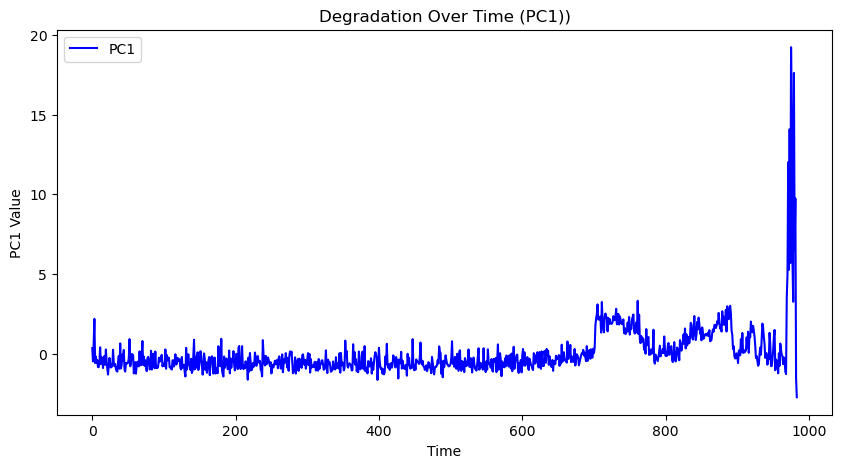

In [23]:

df_pca = pd.DataFrame(principal_components, columns=["PC1"])
df_pca["time"] = df_bear1.index  # Keep cycle index for plotting

plt.figure(figsize=(10, 5))
plt.plot(df_pca["time"], df_pca["PC1"], label="PC1", color='b')
plt.xlabel("Time")
plt.ylabel("PC1 Value")
plt.title("Degradation Over Time (PC1))")
plt.legend()
plt.show()


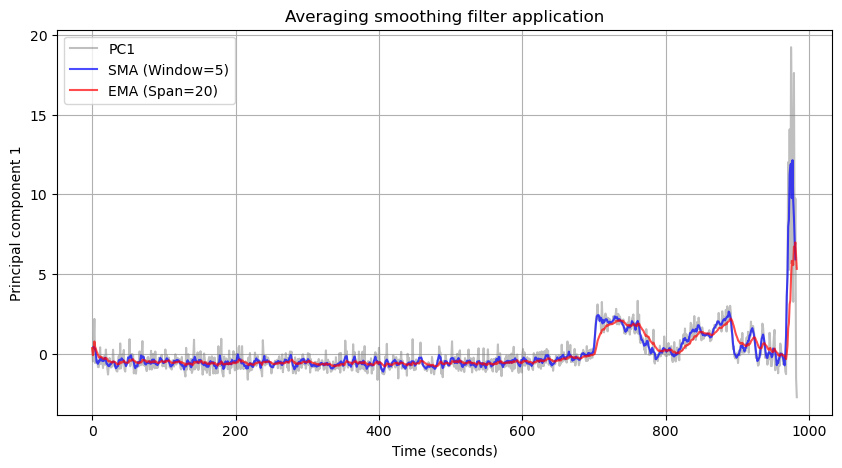

In [24]:
# apply smoothing window

df_pca["PC1_average_smooth"] = df_pca["PC1"].rolling(window=5, center=True).mean()

df_pca['PC1_exponential_smooth'] = df_pca["PC1"].ewm(span=20).mean()   

plt.figure(figsize=(10, 5))
# Plot PC1
plt.plot(df_pca["time"], df_pca["PC1"], label="PC1", color="gray", alpha=0.5)
# Plot moving average (SMA)
plt.plot(df_pca["time"], df_pca["PC1_average_smooth"], label="SMA (Window=5)", color="blue", alpha=0.7)
# Plot exponential smoothing (EMA)
plt.plot(df_pca["time"], df_pca["PC1_exponential_smooth"], label="EMA (Span=20)", color="red", alpha=0.7)

plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Principal component 1")
plt.title("Averaging smoothing filter application")
plt.legend()
plt.grid()

# PCA-based Health Indicator

In [25]:
df_pca

,PC1,time,PC1_average_smooth,PC1_exponential_smooth
0,0.340196,0,NaN,0.340196
1,-0.493616,1,NaN,-0.097555
2,0.671050,2,0.421344,0.184672
3,2.180135,3,0.316409,0.760731
4,-0.591047,4,0.302001,0.433748
...,...,...,...,...
979,17.622446,979,8.551160,6.710317
980,6.493399,980,7.115210,6.689658
981,9.741687,981,5.916819,6.980328
982,-1.534231,982,NaN,6.169417


In [26]:

from scipy.optimize import curve_fit

def fit_exp(df, base=450, print_parameters=True):
    """
    Fits an exponential model to the degradation trend (PC1_exponential_smooth).
    Uses only the last 'base' cycles for better fit.
    """
    x = df["time"].values[-base:].copy()  # Last 'base' cycles
    y = df["PC1_exponential_smooth"].values[-base:].copy()  # Smoothed PC1

    def exp_fit(x, a, b):
        return a * np.exp(abs(b) * x)

    # Fit the exponential model
    fit = curve_fit(exp_fit, x, y, p0=[0.01, 0.001], maxfev=10000)

    if print_parameters:
        print(f"Fitted parameters: a={fit[0][0]:.6f}, b={fit[0][1]:.6f}")

    return fit

# Fit the exponential model
fit_params = fit_exp(df_pca, base=450, print_parameters=True)


Fitted parameters: a=0.002889, b=0.006642


In [27]:
# Set failure threshold (adjust based on degradation trend)
thres = 2  

# Extract fitted parameters
a, b = fit_params[0]

# Calculate the failure cycle
fail_cycle = np.log(thres / a) / abs(b)
print(f"Predicted failure cycle: {fail_cycle:.2f}")


Predicted failure cycle: 984.56


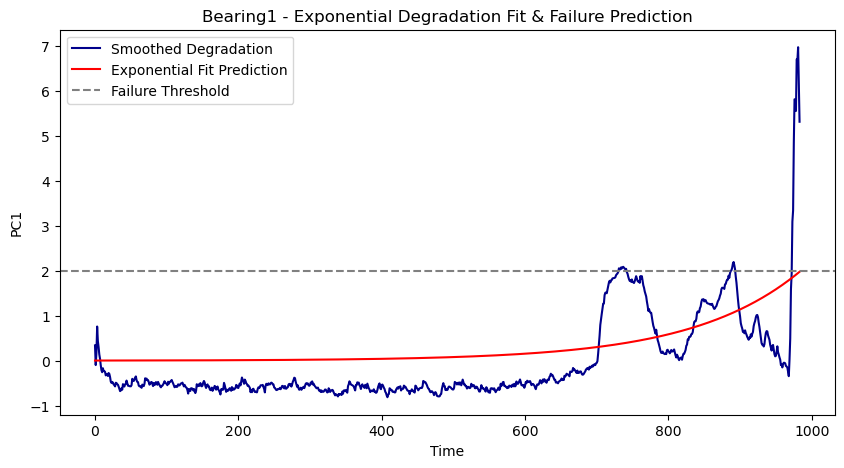

In [28]:

# Generate predictions using the fitted model
predicted_trend = a * np.exp(abs(b) * df_pca["time"].values)

plt.figure(figsize=(10, 5))
plt.plot(df_pca["time"], df_pca["PC1_exponential_smooth"], 'darkblue', label="Smoothed Degradation")
plt.plot(df_pca["time"], predicted_trend, 'red', label="Exponential Fit Prediction")
plt.axhline(y=thres, color='grey', linestyle="--", label="Failure Threshold")
plt.xlabel("Time")
plt.ylabel("PC1")
plt.legend()
plt.title("Bearing1 - Exponential Degradation Fit & Failure Prediction")
plt.show()


In [29]:
df

,file_name,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_rms,B1_max,B1_p2p,B1_crest,B1_clearance,...,B4_kurtosis,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearance,B4_shape,B4_impulse,B4_entropy,time
0,2004.02.12.10.32.39,-0.010196,0.073475,0.083993,0.628763,0.074179,0.454,0.840,6.120331,9.258404,...,0.065959,0.054103,0.193,0.457,4.879539,7.281349,1.256323,6.130277,4.494223,1
1,2004.02.12.10.42.39,-0.002585,0.075338,0.052142,0.648291,0.075382,0.369,0.757,5.147086,7.834513,...,0.107539,0.056101,0.249,0.478,4.438435,6.646340,1.259563,5.590488,4.545821,2
2,2004.02.12.10.52.39,-0.002484,0.076189,0.032808,0.513475,0.076230,0.503,0.903,6.598472,9.907938,...,0.257236,0.056145,0.354,0.688,6.305078,9.483004,1.263337,7.965439,4.544766,3
3,2004.02.12.11.02.39,-0.002277,0.078691,0.041486,1.157953,0.078724,0.608,1.184,7.723217,11.794197,...,0.806190,0.056807,0.513,1.038,9.241749,13.819612,1.260116,11.645678,4.553724,4
4,2004.02.12.11.12.39,-0.002404,0.078437,0.028224,0.603177,0.078474,0.391,0.782,4.982524,7.622802,...,0.138954,0.056841,0.244,0.456,4.292680,6.429704,1.259820,5.408004,4.560095,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,2004.02.19.05.42.39,-0.002752,0.724996,-0.510556,12.577705,0.725001,4.998,9.998,6.896538,14.191571,...,-0.093287,0.148351,0.542,1.086,3.666976,5.376978,1.246204,4.569801,5.447635,980
980,2004.02.19.05.52.39,-0.004487,0.461990,-0.325368,3.759972,0.462012,2.688,5.569,6.235773,10.401209,...,0.259591,0.116630,0.527,0.976,4.518571,6.804165,1.266029,5.720640,5.271184,981
981,2004.02.19.06.02.39,-0.001703,0.483832,-0.377095,4.891755,0.483835,3.501,7.197,7.638962,12.857363,...,0.697167,0.130582,0.625,1.104,4.786252,7.451689,1.295288,6.199577,5.302012,982
982,2004.02.19.06.12.39,0.001857,0.000987,0.579698,3.637513,0.002103,0.005,0.005,2.377543,3.192021,...,1.652722,0.002154,0.005,0.007,2.321622,3.649668,1.205903,2.799650,0.758392,983


Apply PCA to bearing 2, 3, 4

In [35]:
from sklearn.decomposition import PCA
import pandas as pd

# Define the features to use for PCA
features_to_select = ['kurtosis', 'max', 'clearance']

# Apply PCA separately for each bearing
pca_results = {}

for bearing_id in [2, 3, 4]:
    # Dynamically select the correct columns for each bearing
    bearing_cols = [f"B{bearing_id}_{feature}" for feature in features_to_select]
    
    # Extract the bearing data
    bearing_data = df[bearing_cols]

    # Apply PCA
    pca = PCA(n_components=1)
    df[f"B{bearing_id}_PC1"] = pca.fit_transform(bearing_data)

    # Apply Exponential Moving Average (EMA) for smoothing
    df[f"B{bearing_id}_PC1_exponential_smooth"] = df[f"B{bearing_id}_PC1"].ewm(span=40, adjust=False).mean()

    # Store PCA results
    pca_results[f"B{bearing_id}"] = {"Explained Variance": pca.explained_variance_ratio_[0]}
    print(f"Bearing {bearing_id} - PC1 Explained Variance: {pca.explained_variance_ratio_[0]:.4f}")



Bearing 2 - PC1 Explained Variance: 0.9758
Bearing 3 - PC1 Explained Variance: 0.9745
Bearing 4 - PC1 Explained Variance: 0.9753


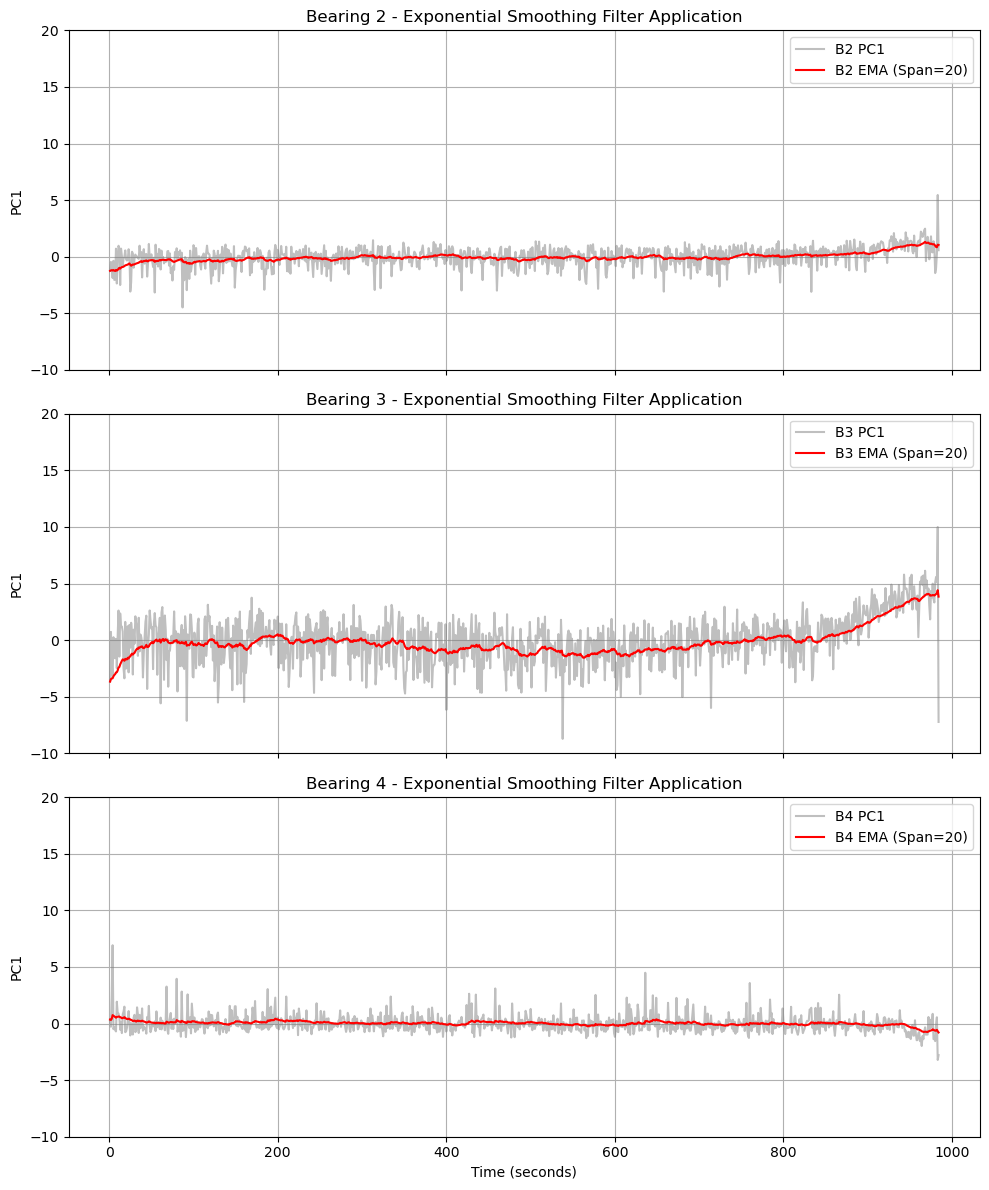

In [36]:
import matplotlib.pyplot as plt

# Create subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot exponential smoothing for Bearings 2, 3, and 4
for i, bearing_id in enumerate([2, 3, 4]):
    col_name = f"B{bearing_id}_PC1"
    smooth_col = f"B{bearing_id}_PC1_exponential_smooth"

    if smooth_col in df.columns:
        ax = axes[i]
        ax.plot(df["time"], df[col_name], color="gray", alpha=0.5, label=f"B{bearing_id} PC1")
        ax.plot(df["time"], df[smooth_col], label=f"B{bearing_id} EMA (Span=20)", linestyle="-", color="red")

        ax.grid()
        ax.set_ylim(-10, 20)
        ax.set_ylabel("PC1")
        ax.set_title(f"Bearing {bearing_id} - Exponential Smoothing Filter Application")
        ax.legend()

# Set common x-axis label
axes[-1].set_xlabel("Time (seconds)")

plt.tight_layout()
plt.show()


Bearing 4 no clear degradation trend

In [37]:
import numpy as np

def predict_failure_cycle(fit_params, threshold=2):
    """
    Uses the fitted exponential model to estimate the cycle at which failure occurs.
    - `fit_params`: Tuple of (a, b) from the exponential fit.
    - `threshold`: The failure threshold (default: 2).
    Returns:
    - Predicted failure cycle when the health indicator reaches the threshold.
    """
    a, b = fit_params[0]  # Extract parameters from curve fitting

    # Compute the failure cycle (solving for x in y = a * exp(bx))
    fail_cycle = np.log(threshold / a) / abs(b)

    return fail_cycle


In [38]:

failure_cycles = {}

for bearing_id in [2, 3, 4]:
    bearing_col = f"B{bearing_id}_PC1_exponential_smooth"

    print(f"\nRunning Failure Prediction for Bearing {bearing_id}")

    bearing_df = df[["time", bearing_col]].copy()
    bearing_df.rename(columns={bearing_col: "PC1_exponential_smooth"}, inplace=True)

    # Fit the exponential model and predict failure
    fit_params = fit_exp(bearing_df, base=300, print_parameters=True)
    fail_cycle = predict_failure_cycle(fit_params, threshold=2)

    failure_cycles[f"B{bearing_id}"] = fail_cycle
    print(f"Predicted failure for Bearing {bearing_id} at cycle: {fail_cycle:.2f}")




Running Failure Prediction for Bearing 2
Fitted parameters: a=0.000001, b=0.014899
Predicted failure for Bearing 2 at cycle: 1008.45

Running Failure Prediction for Bearing 3
Fitted parameters: a=0.000001, b=0.015650
Predicted failure for Bearing 3 at cycle: 924.04

Running Failure Prediction for Bearing 4
Fitted parameters: a=-0.000000, b=-0.029735
Predicted failure for Bearing 4 at cycle: nan


C:\Users\bingh\AppData\Local\Temp\ipykernel_29980\3893464556.py:14: RuntimeWarning: invalid value encountered in log
  fail_cycle = np.log(threshold / a) / abs(b)


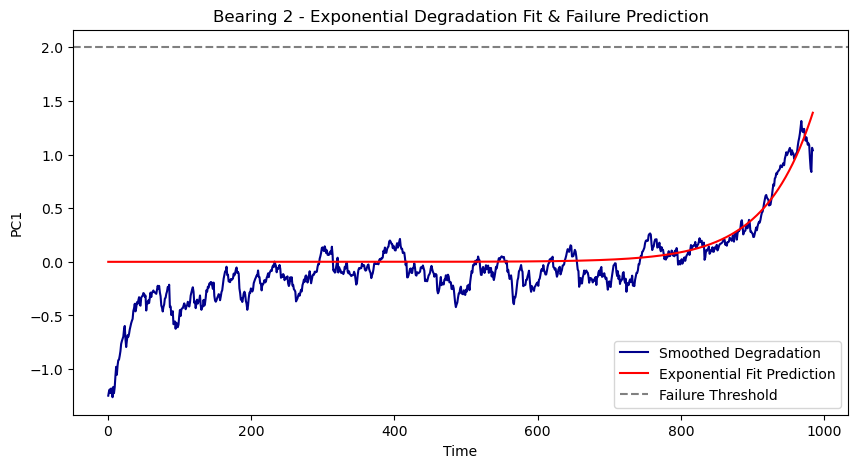

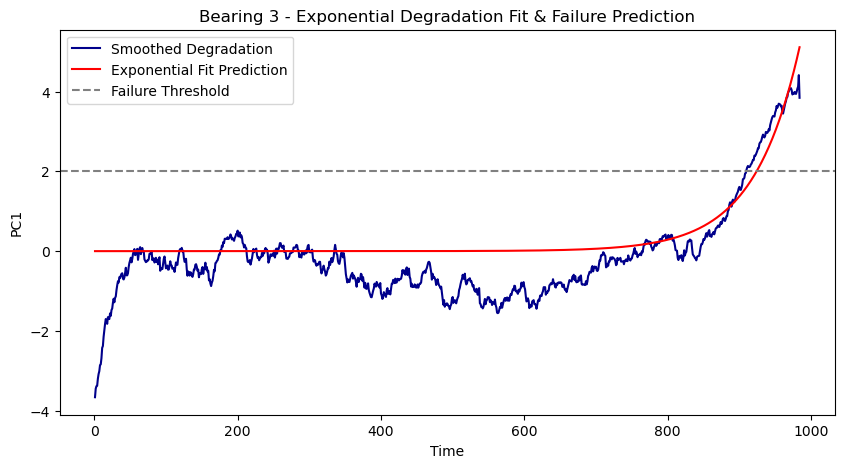

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Plot exponential fit for Bearings 2 and 3
for bearing_id in [2, 3]:
    col_name = f"B{bearing_id}_PC1_exponential_smooth"

    if col_name in df.columns:
        # Get fitted parameters for the bearing
        fit_params = fit_exp(df[["time", col_name]].rename(columns={col_name: "PC1_exponential_smooth"}), base=300, print_parameters=False)
        a, b = fit_params[0]

        # Generate predictions using the fitted model
        predicted_trend = a * np.exp(abs(b) * df["time"].values)

        # Plot degradation trend and exponential fit
        plt.figure(figsize=(10, 5))
        plt.plot(df["time"], df[col_name], 'darkblue', label="Smoothed Degradation")
        plt.plot(df["time"], predicted_trend, 'red', label="Exponential Fit Prediction")
        plt.axhline(y=2, color='grey', linestyle="--", label="Failure Threshold")  # Adjusted threshold

        plt.xlabel("Time")
        plt.ylabel("PC1")
        plt.legend()
        plt.title(f"Bearing {bearing_id} - Exponential Degradation Fit & Failure Prediction")
        plt.show()
